* 整理自链接： https://hrl.boyuai.com/chapter/2/actor-critic%E7%AE%97%E6%B3%95

&&  https://gymnasium.farama.org/tutorials/training_agents/reinforce_invpend_gym_v26/

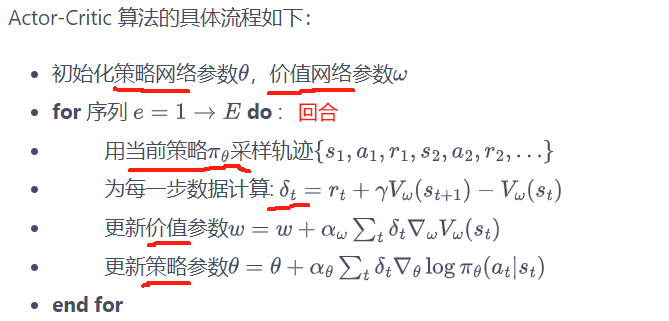

# Code

In [11]:
!pip install gymnasium

In [12]:
import gymnasium as gym
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 这样 无需 plt.show()  直接在代码单元下方显示图
from tqdm import tqdm
import random
import collections
# import rl_utils

# https://github.com/boyu-ai/Hands-on-RL/blob/main/rl_utils.py

import warnings   # 忽略警告
warnings.filterwarnings("ignore")

##   类模块

### PolicyNet 策略网络 (actor)

In [13]:
class PolicyNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    return F.softmax(self.fc2(x), dim=1)

### 价值网络 (critic)

In [14]:
class ValueNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim) # 全连接层
    self.fc2 = torch.nn.Linear(hidden_dim, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x)) # 隐藏层 使用 ReLU 激活函数
    return self.fc2(x)

### Actor-Critic 算法

In [15]:
class ActorCritic:
  """ Actor-Critic 算法"""
  def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device):
    # 策略 网络
    self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
    # 价值 网络
    self.critic = ValueNet(state_dim, hidden_dim).to(device)
    # 使用 Adam 优化器
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    self.gamma = gamma # 折扣因子
    self.device = device

  def take_action(self, state): # 遵循 当前策略 选取动作
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    probs = self.actor(state)
    action = torch.distributions.Categorical(probs).sample().item()
    return action

  def update(self, transition_dict): # 每回合 更新一次
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device) # view(-1, 1) 数据维度修改为 1 列， 行数自适应
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1,1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1,1).to(self.device)

    # 时序差分目标
    td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
    # 时序差分误差
    td_delta = td_target - self.critic(states) # r + γV(s_{t+1}) - V(s_t)
    log_probs = torch.log(self.actor(states).gather(1, actions))

    # 计算损失
    actor_loss = torch.mean(-log_probs * td_delta.detach())
    critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))  # 均方误差损失函数

    # 更新 策略网络
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()
    # 更新价值网络
    self.critic_optimizer.zero_grad()  # 梯度重置为 0
    critic_loss.backward() # 反向传播
    self.critic_optimizer.step() # 更新

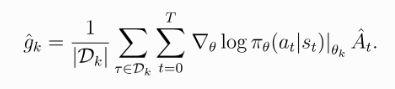

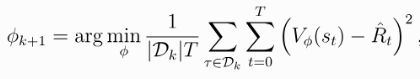

## 训练


环境链接： https://gymnasium.farama.org/environments/classic_control/cart_pole/

In [16]:
# Create and wrap the environment
env_name = "CartPole-v1"
env = gym.make(env_name)
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward
# # deque_size – The size of the buffers return_queue and length_queue  本代码中 打印的回报均值 为 50 个回合的均值

total_num_episodes = 2000  # 回合总数 M
hidden_dim = 128
actor_lr = 1e-3    # 学习率
critic_lr = 1e-2
gamma = 0.98       # 折扣因子 γ
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

# Observation-space of
state_dim = env.observation_space.shape[0]
# Action-space of
action_dim = env.action_space.n
rewards_over_seeds = []

for seed in [0, 42, 2024, 10, 15]:  #  seeds
    # set seed
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)

    reward_over_episodes = []

    # on-policy同策略
    for episode in range(total_num_episodes):
        transition_dict = {'states':[], 'actions':[], 'next_states':[], 'rewards':[], 'dones':[]}
        state, info = wrapped_env.reset(seed=seed)
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = wrapped_env.step(action)
            done = terminated or truncated

            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)

            state = next_state

        agent.update(transition_dict) # 回合结束更新
        reward_over_episodes.append(wrapped_env.return_queue[-1])

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds.append(reward_over_episodes)

# CartPole-v1
# 奖励阈值为 500
# 回合长度阈值为 500

# 运行时长： CPU  14:13 -

Episode: 0 Average Reward: 12
Episode: 1000 Average Reward: 496
Episode: 0 Average Reward: 490
Episode: 1000 Average Reward: 494
Episode: 0 Average Reward: 490
Episode: 1000 Average Reward: 473
Episode: 0 Average Reward: 491
Episode: 1000 Average Reward: 500
Episode: 0 Average Reward: 490
Episode: 1000 Average Reward: 485


## 可视化

https://seaborn.pydata.org/generated/seaborn.lineplot.html

[Text(0.5, 1.0, 'DQN for CartPole-v1')]

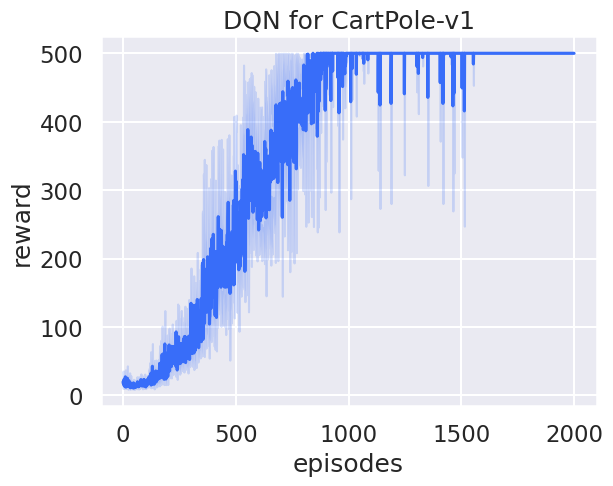

In [17]:
import pandas as pd
import seaborn as sns

rewards_to_plot = [[ reward  for reward in rewards] for rewards in rewards_over_seeds]

df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="DQN for {}".format(env_name)
)

[Text(0.5, 1.0, 'DQN for CartPole-v1')]

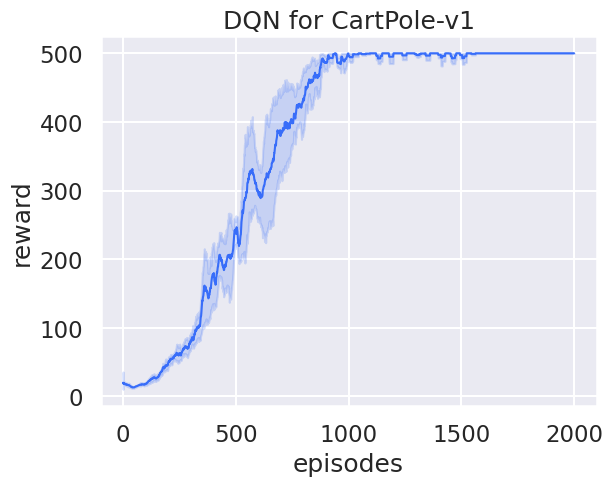

In [18]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

rewards_to_plot = [[ reward  for reward in rewards] for rewards in rewards_over_seeds]
# print(rewards_to_plot)
for i in range(len(rewards_to_plot)):
  rewards_to_plot[i] = moving_average(rewards_to_plot[i], 19) # 调这里 更改平滑度

df1 = pd.DataFrame(rewards_to_plot).melt()  #  .rolling(window=30).mean()

df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1, linewidth=1.5).set(
    title="DQN for {}".format(env_name)
)   # 调线宽

# CartPole-v1
# 奖励阈值为 500
# 回合长度阈值为 500

Actor-Critic 算法很快便能收敛到最优策略，并且训练过程非常稳定，抖动情况相比 REINFORCE 算法有了明显的改进，这说明**价值函数的引入减小了方差。**


价值模块 Critic 在策略模块 Actor 采样的数据中学习分辨什么是好的动作，什么不是好的动作，进而指导 Actor 进行策略更新。

随着 Actor 的训练的进行，其与环境交互所产生的数据分布也发生改变，这**需要 Critic 尽快适应新的数据分布并给出好的判别**。

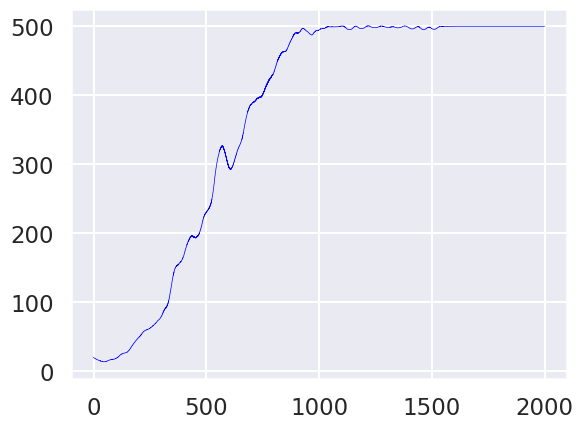

In [19]:
from scipy.signal import savgol_filter
%matplotlib inline

# 应用平滑滤波器
window_size = 300  # 窗口大小，即平滑的程度
polyorder = 2     # 多项式的阶数

# 对 y 值使用 savgol_filter
smoothed_y = savgol_filter(df1['reward'], window_length=window_size, polyorder=polyorder)

# 绘制平滑后的线图
plt.plot(df1['episodes'], smoothed_y, color='blue', linewidth=0.5)   # 2

# 将训练结果 存到 本地， 方便后续进行比较 (DataFrame && csv)


https://pandas.pydata.org/docs/user_guide/10min.html#importing-and-exporting-data

In [20]:
print(YES)

NameError: name 'YES' is not defined

In [21]:
import os
# 查看当前目录
print(os.getcwd())

/content


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
%cd /content/drive/MyDrive/Actor-Critics_Test
!ls

# 在 目录 /content/drive/MyDrive 下新建一个文件夹 Actor-Critics_Test

/content/drive/MyDrive/Actor-Critics_Test


In [25]:
ActorCritics_df = pd.DataFrame(
    {
        "Q Actor-Critic": smoothed_y
    }
)

ActorCritics_df.to_csv("/content/drive/MyDrive/Actor-Critics_Test/Actor-Critics.csv")

In [27]:
my_df_loaded = pd.read_csv('/content/drive/MyDrive/Actor-Critics_Test/Actor-Critics.csv', index_col=0)   # index_col=0 指定行索引的位置
my_df_loaded

,Q Actor-Critic
0,20.035910
1,19.991691
2,19.947628
3,19.903722
4,19.859971
...,...
9995,500.000000
9996,500.000000
9997,500.000000
9998,500.000000
